In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline


# Read in calibration image
images = glob.glob('/Users/ntaheria/CarND-Advanced-Lane-Lines/camera_cal/calibration*.jpg')

# Array to store object points and image points 
objpoints = []
imgpoints = []

nx = 9
ny = 6

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[0:2], None, None)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

for fname in images:
    img = mpimg.imread(fname)
    # convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If corners found, add objpoints, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

In [4]:
# A function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def corners_unwarp(img):
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes    
    dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M

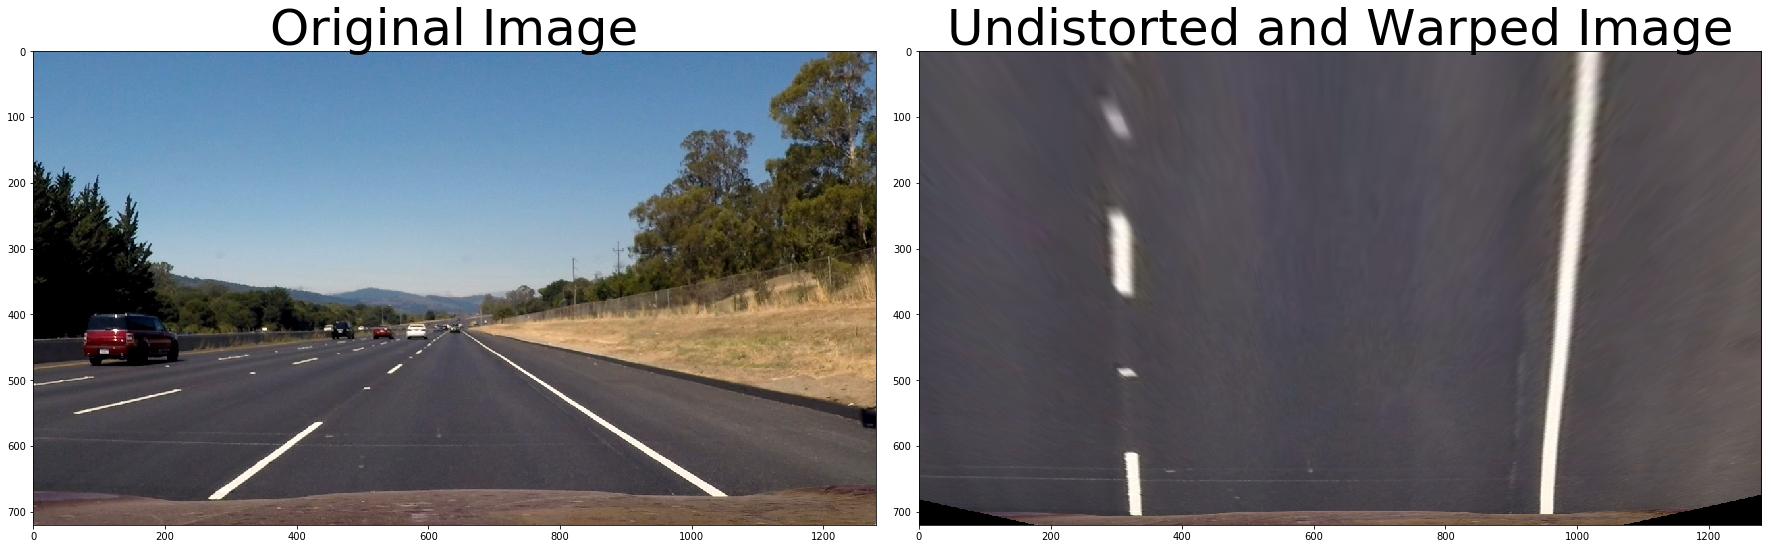

In [8]:
import scipy.misc
img = mpimg.imread('test_images/straight_lines2.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[0:2], None, None)
undist = cal_undistort(img, objpoints, imgpoints)
top_down, perspective_M = corners_unwarp(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

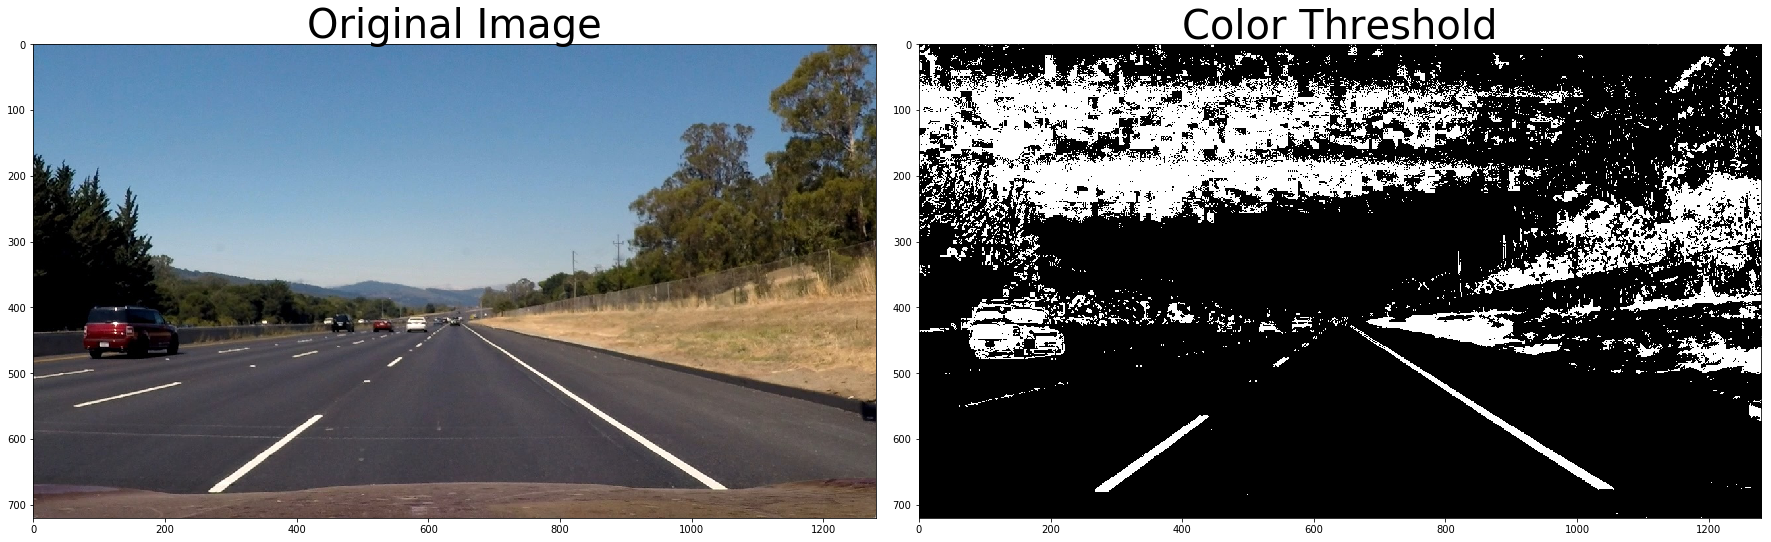

In [24]:
from numpy.linalg import inv
# Edit this function to create your own pipeline.
def color_threshold(img, s_thresh=(100, 255), sx_thresh=(50, 150)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary

result = color_threshold(img,s_thresh=(100, 255), sx_thresh=(50, 150))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Color Threshold', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
scipy.misc.imsave('color_threshold.jpg', result)


In [29]:
def my_pipeline(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    top_down, perspective_M = corners_unwarp(undist)
    binary_warped = color_threshold(top_down, s_thresh=(100, 255), sx_thresh=(50, 150))
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = cv2.cvtColor(out_img, cv2.COLOR_HLS2RGB)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    leftx = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx = right_fitx[::-1]  # Reverse to match top-to-bottom in y
    
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #color_warp = out_img

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, inv(perspective_M), (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result

2322.70522059 m 29887.27633 m


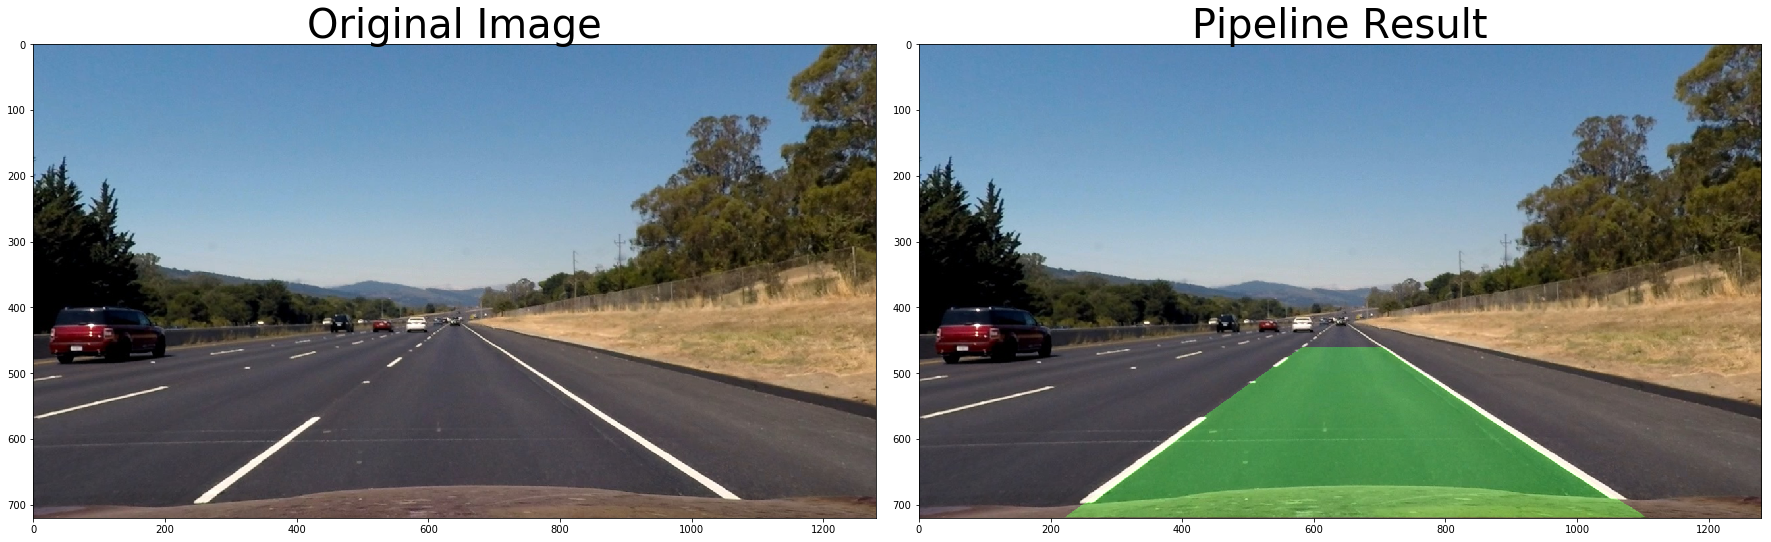

In [30]:
img = mpimg.imread('test_images/straight_lines2.jpg')
result = my_pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
scipy.misc.imsave('result.jpg', result)

In [31]:
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
imageio.plugins.ffmpeg.download()

In [32]:
white_output = 'project_output.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(my_pipeline).subclip(0,5) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

648.001411181 m 1898.14447345 m
648.001411181 m 1898.14447345 m
[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


  1%|          | 1/126 [00:01<03:39,  1.76s/it]

648.001411181 m 1898.14447345 m


  2%|▏         | 2/126 [00:03<03:53,  1.88s/it]

646.33705259 m 1362.4906512 m


  2%|▏         | 3/126 [00:05<03:58,  1.94s/it]

618.709291543 m 1740.51004837 m


  3%|▎         | 4/126 [00:07<03:56,  1.94s/it]

598.044037328 m 1145.64540718 m


  4%|▍         | 5/126 [00:09<03:55,  1.94s/it]

628.955061021 m 917.829108484 m


  5%|▍         | 6/126 [00:11<03:49,  1.91s/it]

639.422711001 m 996.479370192 m


  6%|▌         | 7/126 [00:13<03:48,  1.92s/it]

655.03784246 m 997.327064897 m


  6%|▋         | 8/126 [00:15<03:45,  1.91s/it]

648.139222543 m 7319.25826019 m


  7%|▋         | 9/126 [00:17<03:44,  1.92s/it]

651.131079532 m 4697.03056638 m


  8%|▊         | 10/126 [00:19<03:39,  1.89s/it]

653.288780403 m 7737.69698862 m


  9%|▊         | 11/126 [00:21<03:31,  1.84s/it]

707.941955069 m 4757.38138454 m


 10%|▉         | 12/126 [00:22<03:24,  1.79s/it]

775.675228508 m 2501.30492548 m


 10%|█         | 13/126 [00:24<03:19,  1.77s/it]

810.025979515 m 1925.65265449 m


 11%|█         | 14/126 [00:26<03:16,  1.75s/it]

868.359692896 m 2248.89525555 m


 12%|█▏        | 15/126 [00:27<03:12,  1.73s/it]

894.498301097 m 3123.57043159 m


 13%|█▎        | 16/126 [00:29<03:08,  1.71s/it]

881.616147012 m 3642.12726591 m


 13%|█▎        | 17/126 [00:31<03:08,  1.73s/it]

950.327943769 m 2434.03398571 m


 14%|█▍        | 18/126 [00:33<03:18,  1.84s/it]

982.295318261 m 980.630054929 m


 15%|█▌        | 19/126 [00:35<03:21,  1.89s/it]

1068.8490507 m 959.234307018 m


 16%|█▌        | 20/126 [00:37<03:16,  1.85s/it]

1096.31663754 m 2394.83448116 m


 17%|█▋        | 21/126 [00:38<03:10,  1.81s/it]

1201.32285846 m 3111.58632777 m


 17%|█▋        | 22/126 [00:40<03:04,  1.78s/it]

1159.10347564 m 6341.59266274 m


 18%|█▊        | 23/126 [00:42<03:01,  1.76s/it]

1070.24882803 m 1860.85901052 m


 19%|█▉        | 24/126 [00:43<02:57,  1.74s/it]

972.181662 m 139921.430969 m


 20%|█▉        | 25/126 [00:45<02:53,  1.72s/it]

846.165498119 m 2231.36752324 m


 21%|██        | 26/126 [00:47<02:52,  1.72s/it]

888.395676491 m 2047.73785351 m


 21%|██▏       | 27/126 [00:49<02:49,  1.71s/it]

811.771453612 m 2284.50833721 m


 22%|██▏       | 28/126 [00:50<02:45,  1.69s/it]

808.217657182 m 2570.80753578 m


 23%|██▎       | 29/126 [00:52<02:43,  1.69s/it]

767.671939928 m 1077.28122289 m


 24%|██▍       | 30/126 [00:54<02:46,  1.73s/it]

664.122678639 m 1091.74693052 m


 25%|██▍       | 31/126 [00:55<02:44,  1.73s/it]

643.30238015 m 1001.73394175 m


 25%|██▌       | 32/126 [00:57<02:47,  1.78s/it]

592.411162878 m 713.919347134 m


 26%|██▌       | 33/126 [00:59<02:47,  1.80s/it]

608.11065007 m 1380.94771604 m


 27%|██▋       | 34/126 [01:01<02:45,  1.80s/it]

579.874400128 m 913.405973774 m


 28%|██▊       | 35/126 [01:03<02:38,  1.74s/it]

552.457544801 m 972.511985809 m


 29%|██▊       | 36/126 [01:04<02:34,  1.72s/it]

537.134167241 m 13942.9171465 m


 29%|██▉       | 37/126 [01:06<02:34,  1.73s/it]

513.637362378 m 1674.73996142 m


 30%|███       | 38/126 [01:08<02:32,  1.74s/it]

485.642185715 m 3748.20580727 m


 31%|███       | 39/126 [01:10<02:36,  1.80s/it]

465.952259444 m 1079.54133957 m


 32%|███▏      | 40/126 [01:12<02:35,  1.81s/it]

462.884456721 m 1889.95725337 m


 33%|███▎      | 41/126 [01:13<02:30,  1.77s/it]

485.663980912 m 2226.81927579 m


 33%|███▎      | 42/126 [01:15<02:24,  1.72s/it]

485.163164759 m 845.763206435 m


 34%|███▍      | 43/126 [01:17<02:22,  1.72s/it]

509.190229745 m 1588.95729231 m


 35%|███▍      | 44/126 [01:18<02:19,  1.70s/it]

539.304180943 m 828.425118216 m


 36%|███▌      | 45/126 [01:20<02:15,  1.67s/it]

543.488563723 m 804.104191032 m


 37%|███▋      | 46/126 [01:21<02:11,  1.64s/it]

564.192682849 m 1035.19379209 m


 37%|███▋      | 47/126 [01:23<02:10,  1.65s/it]

590.583227272 m 2013.15556491 m


 38%|███▊      | 48/126 [01:25<02:10,  1.68s/it]

610.169021865 m 1226.17279146 m


 39%|███▉      | 49/126 [01:27<02:11,  1.71s/it]

664.571751697 m 1234.56921432 m


 40%|███▉      | 50/126 [01:28<02:08,  1.69s/it]

703.014226322 m 1488.62753574 m


 40%|████      | 51/126 [01:30<02:10,  1.74s/it]

749.495165922 m 3599.55231749 m


 41%|████▏     | 52/126 [01:32<02:08,  1.74s/it]

825.802159114 m 199499.606042 m


 42%|████▏     | 53/126 [01:33<02:05,  1.72s/it]

831.10076339 m 1302.56571952 m


 43%|████▎     | 54/126 [01:35<02:03,  1.71s/it]

933.913113544 m 1163.01216543 m


 44%|████▎     | 55/126 [01:37<02:02,  1.72s/it]

1146.60531174 m 1611.17288539 m


 44%|████▍     | 56/126 [01:39<01:59,  1.71s/it]

1186.29998632 m 806.650720194 m


 45%|████▌     | 57/126 [01:40<01:58,  1.71s/it]

1269.67142602 m 746.096220067 m


 46%|████▌     | 58/126 [01:42<01:55,  1.70s/it]

1330.71553677 m 832.868820742 m


 47%|████▋     | 59/126 [01:44<01:52,  1.68s/it]

1096.35293731 m 780.402497852 m


 48%|████▊     | 60/126 [01:45<01:49,  1.65s/it]

965.511335005 m 921.24264419 m


 48%|████▊     | 61/126 [01:47<01:47,  1.65s/it]

830.31804186 m 1156.13353602 m


 49%|████▉     | 62/126 [01:48<01:44,  1.63s/it]

772.416199118 m 1219.57709724 m


 50%|█████     | 63/126 [01:50<01:42,  1.62s/it]

788.821381821 m 1639.05897101 m


 51%|█████     | 64/126 [01:52<01:40,  1.63s/it]

730.545641763 m 1531.42667341 m


 52%|█████▏    | 65/126 [01:53<01:40,  1.64s/it]

679.105596314 m 2441.1252284 m


 52%|█████▏    | 66/126 [01:55<01:41,  1.69s/it]

666.318698284 m 1960.40515934 m


 53%|█████▎    | 67/126 [01:57<01:40,  1.69s/it]

682.761101476 m 1312.67524481 m


 54%|█████▍    | 68/126 [01:58<01:36,  1.67s/it]

703.161835672 m 4205.98582055 m


 55%|█████▍    | 69/126 [02:00<01:34,  1.66s/it]

691.435605346 m 893.463509235 m


 56%|█████▌    | 70/126 [02:02<01:34,  1.69s/it]

717.44421592 m 1957.31762598 m


 56%|█████▋    | 71/126 [02:04<01:33,  1.69s/it]

764.412023703 m 674.256669511 m


 57%|█████▋    | 72/126 [02:05<01:31,  1.70s/it]

815.347542552 m 751.403564659 m


 58%|█████▊    | 73/126 [02:07<01:29,  1.69s/it]

898.441140275 m 945.858205241 m


 59%|█████▊    | 74/126 [02:09<01:27,  1.69s/it]

989.203673132 m 991.257609612 m


 60%|█████▉    | 75/126 [02:10<01:25,  1.68s/it]

1137.91400222 m 1149.74204091 m


 60%|██████    | 76/126 [02:12<01:23,  1.67s/it]

1214.37692918 m 963.366671745 m


 61%|██████    | 77/126 [02:14<01:21,  1.67s/it]

1380.29582133 m 2803.61647146 m


 62%|██████▏   | 78/126 [02:15<01:20,  1.67s/it]

1561.52664545 m 6265.37092899 m


 63%|██████▎   | 79/126 [02:17<01:18,  1.68s/it]

1598.64408894 m 1111.82994073 m


 63%|██████▎   | 80/126 [02:19<01:16,  1.67s/it]

1713.67783252 m 873.794854864 m


 64%|██████▍   | 81/126 [02:20<01:14,  1.66s/it]

1954.09016073 m 832.281971751 m


 65%|██████▌   | 82/126 [02:22<01:12,  1.66s/it]

1770.04091232 m 810.735588743 m


 66%|██████▌   | 83/126 [02:24<01:10,  1.65s/it]

1571.74319412 m 687.378384977 m


 67%|██████▋   | 84/126 [02:25<01:09,  1.66s/it]

1734.32199789 m 645.302240977 m


 67%|██████▋   | 85/126 [02:27<01:08,  1.66s/it]

1501.42848347 m 630.093537568 m


 68%|██████▊   | 86/126 [02:29<01:05,  1.65s/it]

1175.81208327 m 825.201539204 m


 69%|██████▉   | 87/126 [02:30<01:04,  1.65s/it]

925.606902628 m 643.257763647 m


 70%|██████▉   | 88/126 [02:32<01:02,  1.65s/it]

821.081795307 m 1015.78263836 m


 71%|███████   | 89/126 [02:33<01:00,  1.64s/it]

725.024771142 m 811.200126029 m


 71%|███████▏  | 90/126 [02:35<00:59,  1.65s/it]

673.023274664 m 756.985179204 m


 72%|███████▏  | 91/126 [02:37<00:57,  1.66s/it]

678.961913423 m 1553.3040448 m


 73%|███████▎  | 92/126 [02:38<00:56,  1.66s/it]

703.706387669 m 1004.90005029 m


 74%|███████▍  | 93/126 [02:40<00:55,  1.67s/it]

706.994811048 m 686.351495434 m


 75%|███████▍  | 94/126 [02:42<00:53,  1.68s/it]

714.874400437 m 1196.89863484 m


 75%|███████▌  | 95/126 [02:44<00:52,  1.68s/it]

723.410222064 m 1403.11379263 m


 76%|███████▌  | 96/126 [02:45<00:50,  1.69s/it]

745.597123412 m 529.12085542 m


 77%|███████▋  | 97/126 [02:47<00:48,  1.68s/it]

767.167741867 m 507.335472638 m


 78%|███████▊  | 98/126 [02:49<00:46,  1.67s/it]

737.190641988 m 564.911852214 m


 79%|███████▊  | 99/126 [02:50<00:45,  1.67s/it]

705.46631918 m 631.097681081 m


 79%|███████▉  | 100/126 [02:52<00:43,  1.66s/it]

737.613913786 m 637.316741574 m


 80%|████████  | 101/126 [02:53<00:41,  1.65s/it]

760.591031422 m 631.818116279 m


 81%|████████  | 102/126 [02:55<00:39,  1.64s/it]

708.360124354 m 548.774243732 m


 82%|████████▏ | 103/126 [02:57<00:37,  1.65s/it]

692.33434927 m 670.687280135 m


 83%|████████▎ | 104/126 [02:58<00:36,  1.65s/it]

678.632569194 m 526.375580328 m


 83%|████████▎ | 105/126 [03:00<00:34,  1.66s/it]

718.264452416 m 601.625551043 m


 84%|████████▍ | 106/126 [03:02<00:33,  1.67s/it]

756.697343676 m 657.237760998 m


 85%|████████▍ | 107/126 [03:03<00:31,  1.67s/it]

750.110488535 m 556.812882562 m


 86%|████████▌ | 108/126 [03:05<00:29,  1.67s/it]

694.970608332 m 1230.02887526 m


 87%|████████▋ | 109/126 [03:07<00:29,  1.75s/it]

695.47467511 m 3467.85317736 m


 87%|████████▋ | 110/126 [03:09<00:29,  1.82s/it]

688.487672557 m 611.532901456 m


 88%|████████▊ | 111/126 [03:11<00:26,  1.80s/it]

677.204625239 m 702.873026408 m


 89%|████████▉ | 112/126 [03:13<00:24,  1.78s/it]

699.79724635 m 1009.5681479 m


 90%|████████▉ | 113/126 [03:14<00:22,  1.74s/it]

663.775371479 m 1062.93149155 m


 90%|█████████ | 114/126 [03:16<00:20,  1.70s/it]

651.293010128 m 36489.0693889 m


 91%|█████████▏| 115/126 [03:17<00:18,  1.68s/it]

584.430662418 m 22355.7488685 m


 92%|█████████▏| 116/126 [03:19<00:16,  1.67s/it]

596.031873125 m 8397.93972419 m


 93%|█████████▎| 117/126 [03:21<00:15,  1.69s/it]

588.631910943 m 1191.94907833 m


 94%|█████████▎| 118/126 [03:23<00:13,  1.74s/it]

585.209336527 m 912.912378643 m


 94%|█████████▍| 119/126 [03:24<00:12,  1.72s/it]

601.350209991 m 573.461172662 m


 95%|█████████▌| 120/126 [03:26<00:10,  1.69s/it]

563.445211359 m 570.363479547 m


 96%|█████████▌| 121/126 [03:28<00:08,  1.68s/it]

531.633305783 m 635.314079672 m


 97%|█████████▋| 122/126 [03:29<00:06,  1.67s/it]

549.935830958 m 1133.20429042 m


 98%|█████████▊| 123/126 [03:31<00:05,  1.68s/it]

540.355088346 m 586.527730584 m


 98%|█████████▊| 124/126 [03:33<00:03,  1.69s/it]

559.456348942 m 955.828640401 m


 99%|█████████▉| 125/126 [03:34<00:01,  1.70s/it]

543.344835284 m 735.726841295 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 3min 35s, sys: 14.1 s, total: 3min 49s
Wall time: 3min 36s


In [33]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [34]:
white_output = 'challenge_output.mp4'

clip1 = VideoFileClip('challenge_video.mp4')
white_clip = clip1.fl_image(my_pipeline).subclip(0,5) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

294.552039543 m 3561.21044452 m
294.552039543 m 3561.21044452 m
[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


  1%|          | 1/150 [00:01<03:52,  1.56s/it]

294.552039543 m 3561.21044452 m


  1%|▏         | 2/150 [00:03<04:03,  1.65s/it]

344.793235281 m 258.039916343 m


  2%|▏         | 3/150 [00:05<04:07,  1.69s/it]

392.382364489 m 293.280210108 m


  3%|▎         | 4/150 [00:06<04:08,  1.70s/it]

191.439204785 m 254.918506148 m


  3%|▎         | 5/150 [00:08<04:08,  1.71s/it]

178.22865247 m 361.732367208 m


  4%|▍         | 6/150 [00:10<04:08,  1.73s/it]

123.983064075 m 423.025544498 m


  5%|▍         | 7/150 [00:12<04:05,  1.72s/it]

93.4072894712 m 1189.59635421 m


  5%|▌         | 8/150 [00:13<03:59,  1.69s/it]

124.665337268 m 1972.71067015 m


  6%|▌         | 9/150 [00:15<03:55,  1.67s/it]

104.322834956 m 1805.46675654 m


  7%|▋         | 10/150 [00:17<03:52,  1.66s/it]

129.112237727 m 790.082185251 m


  7%|▋         | 11/150 [00:18<03:52,  1.67s/it]

121.841722992 m 645.861734954 m


  8%|▊         | 12/150 [00:20<03:49,  1.66s/it]

114.76685365 m 518.350260143 m


  9%|▊         | 13/150 [00:22<03:47,  1.66s/it]

118.155668697 m 397.123311284 m


  9%|▉         | 14/150 [00:23<03:44,  1.65s/it]

123.332869585 m 254.23570276 m


 10%|█         | 15/150 [00:25<03:44,  1.66s/it]

274.734243405 m 300.291407994 m


 11%|█         | 16/150 [00:26<03:40,  1.65s/it]

156.253806301 m 254.042957949 m


 11%|█▏        | 17/150 [00:28<03:39,  1.65s/it]

114.700082916 m 331.499577976 m


 12%|█▏        | 18/150 [00:30<03:40,  1.67s/it]

84.7639697589 m 468.451252627 m


 13%|█▎        | 19/150 [00:32<03:41,  1.69s/it]

91.9278099993 m 7576.21499999 m


 13%|█▎        | 20/150 [00:33<03:38,  1.68s/it]

100.906246293 m 354.379751196 m


 14%|█▍        | 21/150 [00:35<03:37,  1.69s/it]

97.2797861709 m 324.302126126 m


 15%|█▍        | 22/150 [00:37<03:35,  1.68s/it]

92.9951902484 m 126.189467536 m


 15%|█▌        | 23/150 [00:38<03:34,  1.69s/it]

92.9012597008 m 110.840631946 m


 16%|█▌        | 24/150 [00:40<03:32,  1.68s/it]

98.7182413045 m 147.784246213 m


 17%|█▋        | 25/150 [00:42<03:29,  1.68s/it]

91.0713134683 m 80.4798730658 m


 17%|█▋        | 26/150 [00:43<03:25,  1.66s/it]

117.415086951 m 79.5930780089 m


 18%|█▊        | 27/150 [00:45<03:27,  1.69s/it]

105.481491467 m 92.266994611 m


 19%|█▊        | 28/150 [00:47<03:26,  1.69s/it]

115.224310583 m 2034.58543182 m


 19%|█▉        | 29/150 [00:48<03:26,  1.70s/it]

108.122313955 m 87.2510239429 m


 20%|██        | 30/150 [00:50<03:25,  1.71s/it]

99.8760449959 m 75.2037468789 m


 21%|██        | 31/150 [00:52<03:19,  1.68s/it]

202.697977445 m 81.8170965822 m


 21%|██▏       | 32/150 [00:53<03:17,  1.67s/it]

347.913132146 m 275.727220534 m


 22%|██▏       | 33/150 [00:55<03:15,  1.67s/it]

111.09334856 m 89.2076910456 m


 23%|██▎       | 34/150 [00:57<03:12,  1.66s/it]

275.507283226 m 69.2215315312 m


 23%|██▎       | 35/150 [00:58<03:06,  1.62s/it]

87.0416995109 m 70.901157699 m


 24%|██▍       | 36/150 [01:00<03:03,  1.61s/it]

84.3305832478 m 87.9190811008 m


 25%|██▍       | 37/150 [01:01<03:02,  1.61s/it]

96.3618741466 m 75.3747641295 m


 25%|██▌       | 38/150 [01:03<02:59,  1.60s/it]

112.777989773 m 91.5867381698 m


 26%|██▌       | 39/150 [01:05<03:02,  1.64s/it]

129.099295091 m 114.349401107 m


 27%|██▋       | 40/150 [01:06<02:59,  1.63s/it]

124.918801274 m 125.802051817 m


 27%|██▋       | 41/150 [01:08<02:56,  1.61s/it]

66.1076896357 m 111.628189569 m


 28%|██▊       | 42/150 [01:10<02:54,  1.62s/it]

67.9255289348 m 476.379790027 m


 29%|██▊       | 43/150 [01:11<02:54,  1.63s/it]

68.519922193 m 89.385748035 m


 29%|██▉       | 44/150 [01:13<02:53,  1.64s/it]

98.0503781428 m 69.329737446 m


 30%|███       | 45/150 [01:15<03:02,  1.74s/it]

85.698964713 m 101.454506963 m


 31%|███       | 46/150 [01:17<03:06,  1.79s/it]

86.7451920072 m 312.707076516 m


 31%|███▏      | 47/150 [01:18<03:00,  1.75s/it]

80.9150838797 m 372.762868065 m


 32%|███▏      | 48/150 [01:20<02:54,  1.71s/it]

83.3530671461 m 128.198912679 m


 33%|███▎      | 49/150 [01:22<02:50,  1.68s/it]

76.9334262077 m 165.698523488 m


 33%|███▎      | 50/150 [01:23<02:50,  1.70s/it]

73.6894674873 m 65.2632383302 m


 34%|███▍      | 51/150 [01:25<02:46,  1.68s/it]

167.563265853 m 348.448519313 m


 35%|███▍      | 52/150 [01:27<02:44,  1.68s/it]

158.869349503 m 263.873142385 m


 35%|███▌      | 53/150 [01:28<02:43,  1.68s/it]

625.745519315 m 110.387430129 m


 36%|███▌      | 54/150 [01:30<02:40,  1.67s/it]

394.652274926 m 63.5230196337 m


 37%|███▋      | 55/150 [01:32<02:40,  1.69s/it]

89.3781137916 m 112.781735728 m


 37%|███▋      | 56/150 [01:33<02:38,  1.69s/it]

81.7041471887 m 81.3274332385 m


 38%|███▊      | 57/150 [01:35<02:38,  1.70s/it]

85.289906014 m 85.3535349214 m


 39%|███▊      | 58/150 [01:37<02:36,  1.70s/it]

100.112013857 m 91.2321151578 m


 39%|███▉      | 59/150 [01:39<02:34,  1.70s/it]

717.391696699 m 112.848699828 m


 40%|████      | 60/150 [01:40<02:34,  1.71s/it]

89.3745537175 m 106.935328338 m


 41%|████      | 61/150 [01:42<02:31,  1.71s/it]

89.8293921275 m 76.2552049561 m


 41%|████▏     | 62/150 [01:44<02:28,  1.69s/it]

93.341247756 m 107.828564665 m


 42%|████▏     | 63/150 [01:45<02:24,  1.66s/it]

91.7562260967 m 729.613707327 m


 43%|████▎     | 64/150 [01:47<02:21,  1.65s/it]

79.0926252514 m 66.3224385235 m


 43%|████▎     | 65/150 [01:49<02:20,  1.65s/it]

3097.53257905 m 71.099532607 m


 44%|████▍     | 66/150 [01:50<02:21,  1.69s/it]

182.348231895 m 81.8346046298 m


 45%|████▍     | 67/150 [01:52<02:20,  1.69s/it]

443.440126268 m 75.9170215608 m


 45%|████▌     | 68/150 [01:54<02:19,  1.70s/it]

1318.05687704 m 382.817948627 m


 46%|████▌     | 69/150 [01:56<02:19,  1.73s/it]

2361.62899746 m 353.038094841 m


 47%|████▋     | 70/150 [01:57<02:18,  1.73s/it]

527.344064562 m 74.1744044959 m


 47%|████▋     | 71/150 [01:59<02:14,  1.70s/it]

65.9411444092 m 85.7218291026 m


 48%|████▊     | 72/150 [02:01<02:10,  1.68s/it]

100.958122696 m 144.759073033 m


 49%|████▊     | 73/150 [02:02<02:08,  1.67s/it]

99.8712461485 m 78.6457972482 m


 49%|████▉     | 74/150 [02:04<02:08,  1.69s/it]

122.246708015 m 201.292766942 m


 50%|█████     | 75/150 [02:06<02:09,  1.73s/it]

66.5295053403 m 276.472812576 m


 51%|█████     | 76/150 [02:07<02:07,  1.73s/it]

65.3939600986 m 74.3094740481 m


 51%|█████▏    | 77/150 [02:09<02:05,  1.72s/it]

65.7725028656 m 84.6214266589 m


 52%|█████▏    | 78/150 [02:11<02:04,  1.73s/it]

66.0830458157 m 71.4773645641 m


 53%|█████▎    | 79/150 [02:13<02:03,  1.74s/it]

67.1692596033 m 79.8481234187 m


 53%|█████▎    | 80/150 [02:14<01:59,  1.71s/it]

70.0214177274 m 70.5717931286 m


 54%|█████▍    | 81/150 [02:16<01:57,  1.70s/it]

77.0433306797 m 82.0023078108 m


 55%|█████▍    | 82/150 [02:18<01:55,  1.70s/it]

105.344447454 m 158.728288339 m


 55%|█████▌    | 83/150 [02:20<01:55,  1.72s/it]

823.469411944 m 112.755204693 m


 56%|█████▌    | 84/150 [02:21<01:55,  1.75s/it]

74.8298948358 m 131.094141631 m


 57%|█████▋    | 85/150 [02:23<01:53,  1.75s/it]

93.7167657648 m 282.214487076 m


 57%|█████▋    | 86/150 [02:25<01:54,  1.78s/it]

75.6509238164 m 72.5674589546 m


 58%|█████▊    | 87/150 [02:27<01:53,  1.80s/it]

138.926297663 m 71.3872799818 m


 59%|█████▊    | 88/150 [02:28<01:47,  1.73s/it]

209.242934505 m 74.9195020508 m


 59%|█████▉    | 89/150 [02:30<01:43,  1.69s/it]

108.527733129 m 358.169676027 m


 60%|██████    | 90/150 [02:32<01:43,  1.73s/it]

657.894916417 m 277.485780476 m


 61%|██████    | 91/150 [02:33<01:41,  1.72s/it]

67.382587497 m 442.922218152 m


 61%|██████▏   | 92/150 [02:35<01:38,  1.69s/it]

77.9407776907 m 455.294283729 m


 62%|██████▏   | 93/150 [02:37<01:36,  1.69s/it]

86.4703892891 m 164.422784577 m


 63%|██████▎   | 94/150 [02:38<01:33,  1.67s/it]

101.4973663 m 711.183370545 m


 63%|██████▎   | 95/150 [02:40<01:31,  1.67s/it]

97.6119588127 m 96.21703235 m


 64%|██████▍   | 96/150 [02:42<01:29,  1.66s/it]

110.733876533 m 95.6046475209 m


 65%|██████▍   | 97/150 [02:44<01:33,  1.76s/it]

108.006405686 m 82.2918031303 m


 65%|██████▌   | 98/150 [02:46<01:34,  1.82s/it]

285.988534028 m 79.2169188079 m


 66%|██████▌   | 99/150 [02:47<01:32,  1.80s/it]

1742.83778357 m 131.092980608 m


 67%|██████▋   | 100/150 [02:49<01:28,  1.77s/it]

134.924620029 m 362.400291103 m


 67%|██████▋   | 101/150 [02:51<01:27,  1.79s/it]

530.83467839 m 435.805226596 m


 68%|██████▊   | 102/150 [02:53<01:24,  1.77s/it]

344.738916316 m 303.640515547 m


 69%|██████▊   | 103/150 [02:54<01:21,  1.73s/it]

4347.51014403 m 118.085520309 m


 69%|██████▉   | 104/150 [02:56<01:17,  1.70s/it]

153.048541424 m 131.69004858 m


 70%|███████   | 105/150 [02:57<01:14,  1.66s/it]

72.9137855431 m 240.071948923 m


 71%|███████   | 106/150 [02:59<01:11,  1.63s/it]

236.893804447 m 268.22245617 m


 71%|███████▏  | 107/150 [03:01<01:09,  1.62s/it]

183.346579871 m 342.677397156 m


 72%|███████▏  | 108/150 [03:02<01:08,  1.62s/it]

63.8015544419 m 455.651126061 m


 73%|███████▎  | 109/150 [03:04<01:07,  1.64s/it]

68.6012756766 m 324.261674235 m


 73%|███████▎  | 110/150 [03:06<01:06,  1.66s/it]

85.8338322633 m 3974.56680291 m


 74%|███████▍  | 111/150 [03:07<01:04,  1.65s/it]

103.310359857 m 1080.08356024 m


 75%|███████▍  | 112/150 [03:09<01:02,  1.65s/it]

120.201433008 m 132.425013825 m


 75%|███████▌  | 113/150 [03:11<01:00,  1.64s/it]

104.366104856 m 159.402813486 m


 76%|███████▌  | 114/150 [03:12<00:59,  1.65s/it]

134.517439183 m 296.486726322 m


 77%|███████▋  | 115/150 [03:14<00:57,  1.63s/it]

546.278946721 m 308.897530596 m


 77%|███████▋  | 116/150 [03:15<00:55,  1.64s/it]

97.9951687053 m 78.2631519352 m


 78%|███████▊  | 117/150 [03:17<00:54,  1.64s/it]

84.7811672612 m 189.665715058 m


 79%|███████▊  | 118/150 [03:19<00:52,  1.64s/it]

74.8859264363 m 299.495645457 m


 79%|███████▉  | 119/150 [03:20<00:50,  1.64s/it]

71.503503696 m 3862.87250594 m


 80%|████████  | 120/150 [03:22<00:48,  1.62s/it]

93.1280426126 m 54401.3601565 m


 81%|████████  | 121/150 [03:24<00:46,  1.60s/it]

91.225705228 m 32526.62729 m


 81%|████████▏ | 122/150 [03:25<00:45,  1.63s/it]

113.361379328 m 66.4366780865 m


 82%|████████▏ | 123/150 [03:27<00:43,  1.62s/it]

193.16235121 m 76.8326503978 m


 83%|████████▎ | 124/150 [03:29<00:43,  1.66s/it]

75.3738594659 m 76.2051953841 m


 83%|████████▎ | 125/150 [03:31<00:44,  1.77s/it]

93.289912651 m 113.805879813 m


 84%|████████▍ | 126/150 [03:33<00:43,  1.82s/it]

357.320506469 m 76.5682245909 m


 85%|████████▍ | 127/150 [03:34<00:41,  1.80s/it]

167.102275228 m 112.453753319 m


 85%|████████▌ | 128/150 [03:36<00:40,  1.83s/it]

85.8356201027 m 97.9581679216 m


 86%|████████▌ | 129/150 [03:38<00:38,  1.85s/it]

86.8005827227 m 82.0295996666 m


 87%|████████▋ | 130/150 [03:40<00:36,  1.81s/it]

93.6543423198 m 87.0306803237 m


 87%|████████▋ | 131/150 [03:41<00:32,  1.73s/it]

534.736510499 m 229.103306365 m


 88%|████████▊ | 132/150 [03:43<00:30,  1.67s/it]

105.488891025 m 1058.40416144 m


 89%|████████▊ | 133/150 [03:45<00:28,  1.68s/it]

186.784349001 m 180.294556917 m


 89%|████████▉ | 134/150 [03:46<00:27,  1.75s/it]

105.967445454 m 420.832483776 m


 90%|█████████ | 135/150 [03:48<00:26,  1.76s/it]

116.825664766 m 263.271022811 m


 91%|█████████ | 136/150 [03:50<00:25,  1.79s/it]

161.38428701 m 344.890702547 m


 91%|█████████▏| 137/150 [03:52<00:24,  1.85s/it]

107.658796015 m 289.909842656 m


 92%|█████████▏| 138/150 [03:54<00:22,  1.89s/it]

71.7633944862 m 322.527458156 m


 93%|█████████▎| 139/150 [03:56<00:20,  1.84s/it]

74.0859071251 m 346.617756601 m


 93%|█████████▎| 140/150 [03:58<00:18,  1.85s/it]

72.1246530921 m 353.053966075 m


 94%|█████████▍| 141/150 [04:00<00:17,  1.92s/it]

79.2599027578 m 1680.45168324 m


 95%|█████████▍| 142/150 [04:02<00:14,  1.86s/it]

304.297833941 m 282.005509242 m


 95%|█████████▌| 143/150 [04:03<00:12,  1.81s/it]

192.766757626 m 317.102288499 m


 96%|█████████▌| 144/150 [04:05<00:10,  1.81s/it]

193.685103704 m 313.679499141 m


 97%|█████████▋| 145/150 [04:07<00:08,  1.79s/it]

192.806132914 m 317.096005937 m


 97%|█████████▋| 146/150 [04:08<00:06,  1.74s/it]

92.0543495517 m 740.159244231 m


 98%|█████████▊| 147/150 [04:10<00:05,  1.68s/it]

896.394151025 m 682.742746165 m


 99%|█████████▊| 148/150 [04:12<00:03,  1.65s/it]

130.803077073 m 598.281647563 m


 99%|█████████▉| 149/150 [04:13<00:01,  1.62s/it]

77.541710178 m 129.0228406 m


100%|██████████| 150/150 [04:15<00:00,  1.60s/it]

112.400064904 m 64.7047381581 m


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 4min 19s, sys: 14.6 s, total: 4min 33s
Wall time: 4min 16s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))